# Imports

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import pandas as pd
import plotly.graph_objects as go


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Data preprocessing

In [2]:
# make df with column names year, month, decimal date, SSN, M1, M2, M3, M4, M5 from file 5c_obs_sim_v1.dat
df = pd.read_csv('5c_obs_sim_v1.dat', sep='\s+', header=None, names=['year', 'month', 'decimal_date', 'SSN', 'M1', 'M2', 'M3', 'M4', 'M5'])

# normalize data to be between 0 and 1 using max value from SSN
M = df['SSN'].max()
df['SSN'] = df['SSN'] / M
for i in range(1, 6):
    df[f'M{i}'] = df[f'M{i}'] / M

df.head()

,year,month,decimal_date,SSN,M1,M2,M3,M4,M5
0,1965,1,1965.042,0.073851,0.0,0.0,0.0,0.004615,0.000511
1,1965,2,1965.123,0.075998,0.0,0.0,0.0,0.005838,0.001198
2,1965,3,1965.204,0.079004,0.0,0.0,0.0,0.007768,0.001380
3,1965,4,1965.288,0.085444,0.0,0.0,0.0,0.010287,0.001755
4,1965,5,1965.371,0.091026,0.0,0.0,0.0,0.013512,0.002240


In [4]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=df['decimal_date'], y=df['SSN'], name='SSN'))

for i in range(1, 6):
    fig.add_trace(go.Scatter(x=df['decimal_date'], y=df[f'M{i}'], name=f'M{i}', visible=True))

fig.update_yaxes(range=[-0.2, 1])
fig.show()

In [3]:
class MixedDataGenerator:
    def __init__(self,
                 model_series,
                 observed_series,
                 previous_values,
                 horizon=18):
        self.model_series = model_series
        self.observed_series = observed_series
        self.horizon = horizon
        self.n_prev = previous_values
        self.X, self.y = self._prepare_data()
        
    def _prepare_data(self):
        l = len(self.model_series) - self.n_prev - self.horizon + 1
        X = np.zeros((l, 2 * self.n_prev + self.horizon))
        y = np.zeros((l, self.horizon))
        for i in range(l):
            X[i, -self.n_prev:] = self.observed_series[i:i + self.n_prev]
            X[i, :-self.n_prev] = self.model_series[i:i + self.n_prev + self.horizon]
            
            # X[i, :self.n_prev] = self.observed_series[i:i + self.n_prev]
            # X[i, self.n_prev:] = self.model_series[i:i + self.n_prev + self.horizon]
            
            y[i] = self.observed_series[i + self.n_prev: i + self.n_prev + self.horizon]
        return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [41]:
model_series = df['M1'].values
observed_series = df['SSN'].values

data = MixedDataGenerator(model_series, observed_series, 4, 18)

In [42]:
train_data_X = data.X[:250]
train_data_y = data.y[:250]

val_data_X = data.X[250:360]
val_data_y = data.y[250:360]

test_data_X = data.X[360:]
test_data_y = data.y[360:]

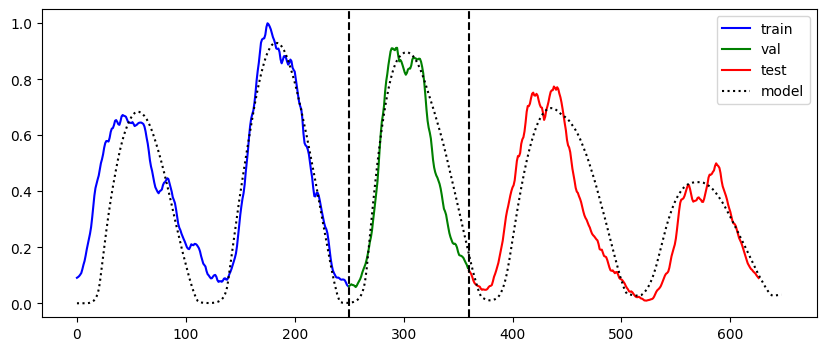

In [44]:
test_val_size = 0.6
val_size = 0.7

# train_data_X, test_data_X, train_data_y, test_data_y = train_test_split(data.X, data.y, test_size=test_val_size, shuffle=False)
# val_data_X, test_data_X, val_data_y, test_data_y = train_test_split(test_data_X, test_data_y, test_size=val_size, shuffle=False)

trainloader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(train_data_X, train_data_y), batch_size=64, shuffle=True)
valloader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(val_data_X, val_data_y), batch_size=64, shuffle=False)


# plot train val test data with 3 different colors and dotted model series. make shift for x axis to show all data
plt.figure(figsize=(10, 4))
plt.plot(train_data_y[:, 0], label='train', color='blue')
# make shift on x to plot val after train
plt.plot(np.arange(len(train_data_y), len(train_data_y) + len(val_data_y)), val_data_y[:, 0], label='val', color='green')
plt.plot(np.arange(len(train_data_y) + len(val_data_y), len(train_data_y) + len(val_data_y) + len(test_data_y)), test_data_y[:, 0], label='test', color='red')
plt.plot(model_series, label='model', color='black', linestyle='dotted')
# add 2 vertical lines to show train val test split
plt.axvline(len(train_data_y), color='black', linestyle='dashed')
plt.axvline(len(train_data_y) + len(val_data_y), color='black', linestyle='dashed')

plt.legend()

In [45]:
test_data_y

tensor([[0.1172, 0.1112, 0.1048,  ..., 0.0481, 0.0485, 0.0515],
        [0.1112, 0.1048, 0.0945,  ..., 0.0485, 0.0515, 0.0575],
        [0.1048, 0.0945, 0.0816,  ..., 0.0515, 0.0575, 0.0614],
        ...,
        [0.1000, 0.0953, 0.0902,  ..., 0.0288, 0.0279, 0.0292],
        [0.0953, 0.0902, 0.0842,  ..., 0.0279, 0.0292, 0.0288],
        [0.0902, 0.0842, 0.0786,  ..., 0.0292, 0.0288, 0.0258]])

# Model building

In [46]:
class NARX(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(NARX, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            # nn.Softplus(),
            nn.Sigmoid(),
            nn.Linear(hidden_size, output_size), 
            nn.Softplus()
            # nn.ReLU()
        )

    def forward(self, x):
        out = self.net(x)
        return out
    
    def train_model(self, trainloader, valloader, data, epochs=100, lr=0.001):
        optimizer = torch.optim.Adam(self.parameters(), lr=lr)
        criterion = nn.MSELoss()
        train_losses = []
        val_losses = []
        autoregressive_rmses = []
        for i in tqdm(range(epochs), desc='Training', unit='epoch'):
            self.train()
            train_loss = 0
            for X, y in trainloader:
                X, y = X.to(device), y.to(device)
                optimizer.zero_grad()
                output = self(X)
                loss = criterion(output, y)
                loss.backward()
                optimizer.step()
                train_loss += loss.item()
            train_losses.append(train_loss / len(trainloader))
            self.eval()
            val_loss = 0
            with torch.no_grad():
                for X, y in valloader:
                    X, y = X.to(device), y.to(device)
                    output = self(X)
                    loss = criterion(output, y)
                    val_loss += loss.item()
                val_losses.append(val_loss / len(valloader))
        
                    
            
        return train_losses, val_losses, autoregressive_rmses
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [110]:
model = NARX(input_size=2 * 4 + 18, hidden_size=24, output_size=18).to(device)
model.to(device)

NARX(
  (net): Sequential(
    (0): Linear(in_features=26, out_features=24, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=24, out_features=18, bias=True)
    (3): Softplus(beta=1, threshold=20)
  )
)

# Training

In [111]:
train_losses, val_losses, autormses = model.train_model(trainloader, valloader, data, epochs=2000, lr=0.001)
fig = go.Figure()
fig.add_trace(go.Scatter(x=np.arange(len(train_losses)), y=train_losses, mode='lines', name='Train Loss'))
fig.add_trace(go.Scatter(x=np.arange(len(val_losses)), y=val_losses, mode='lines', name='Validation Loss'))
fig.update_layout(title='Training and Validation Loss', xaxis_title='Epoch', yaxis_title='Loss')
fig.show()

Training: 100%|██████████| 2000/2000 [00:32<00:00, 62.02epoch/s]


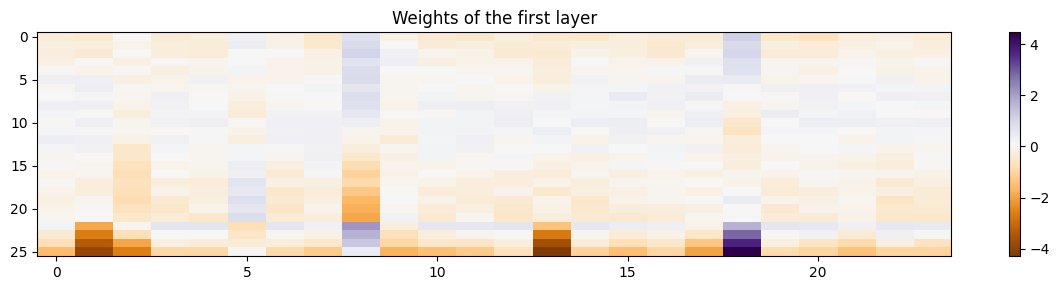

In [112]:
# plot weights of first layer as 2D image
plt.figure(figsize=(12, 3))
plt.imshow(model.net[0].weight.detach().cpu().numpy().T, aspect='auto', cmap='PuOr')
plt.colorbar()
plt.title('Weights of the first layer')
plt.tight_layout()
plt.show()

# Results

In [113]:
model.eval()
x = data.X.to(device)
y = data.y.to(device)
preds = model(x.to(device))


fig = go.Figure()
fig.add_trace(go.Scatter(y=y.cpu().numpy()[:, 0], name='True', mode='lines', line=dict(color='green')))
fig.add_trace(go.Scatter(y=preds.detach().cpu().numpy()[:, 0], name='Predicted', mode='lines', line=dict(color='red')))
# train-val line
fig.add_shape(type='line', x0=(1 - test_val_size) * len(x), x1=(1 - test_val_size) * len(x), y0=0, y1=1, line=dict(color='gray', width=1, dash='dash'))
fig.add_shape(type='line', x0=0.8 * len(x), x1=0.8 * len(x), y0=0, y1=1, line=dict(color='gray', width=1, dash='dash'))
# add M1
fig.add_trace(go.Scatter(y=model_series, name='M1', mode='lines', line=dict(color='blue', dash='dash', width=1)))
fig.update_layout(title='Results', xaxis_title='Time', yaxis_title='Value')
fig.show()


In [114]:
# make preds for test data
test_data_X = test_data_X.to(device)
test_data_y = test_data_y.to(device)
preds = model(test_data_X)
rmses = (preds - test_data_y).pow(2).mean(dim=0).sqrt() * M

for i, rmse in enumerate(rmses):
    print(f'RMSE for step {i + 1}: {rmse.item():.2f}')

RMSE for step 1: 4.18
RMSE for step 2: 5.56
RMSE for step 3: 6.86
RMSE for step 4: 8.59
RMSE for step 5: 9.71
RMSE for step 6: 11.14
RMSE for step 7: 12.01
RMSE for step 8: 13.19
RMSE for step 9: 14.26
RMSE for step 10: 15.24
RMSE for step 11: 16.28
RMSE for step 12: 17.03
RMSE for step 13: 17.88
RMSE for step 14: 18.61
RMSE for step 15: 19.36
RMSE for step 16: 20.16
RMSE for step 17: 20.97
RMSE for step 18: 21.74


In [127]:
def plot_pred(start, folder_name):
    preds_auto = preds[start]

    # plot autoregressive prediction
    plt.figure(figsize=(15, 5))
    plt.plot(test_data_y[:, 0].detach().cpu() * M, label='True', color='green')

    # X axis for preds_auto and model_series
    x_range = range(start, start + len(preds_auto))  # Для preds_auto
    x_range_series = range(start, start + len(model_series[start: start + 18]))  # Для model_series

    # Plot preds_auto and model_series from start
    plt.plot(x_range, preds_auto.detach().cpu() * M, label='Predicted', color='red')
    plt.plot(model_series[360:] * M, label='M1', linestyle='--', color='blue', alpha=0.5)

    plt.title('Prediction')
    plt.legend()
    plt.tight_layout()
    plt.savefig(f'results/{folder_name}/ex_{start}.png')
    plt.show()

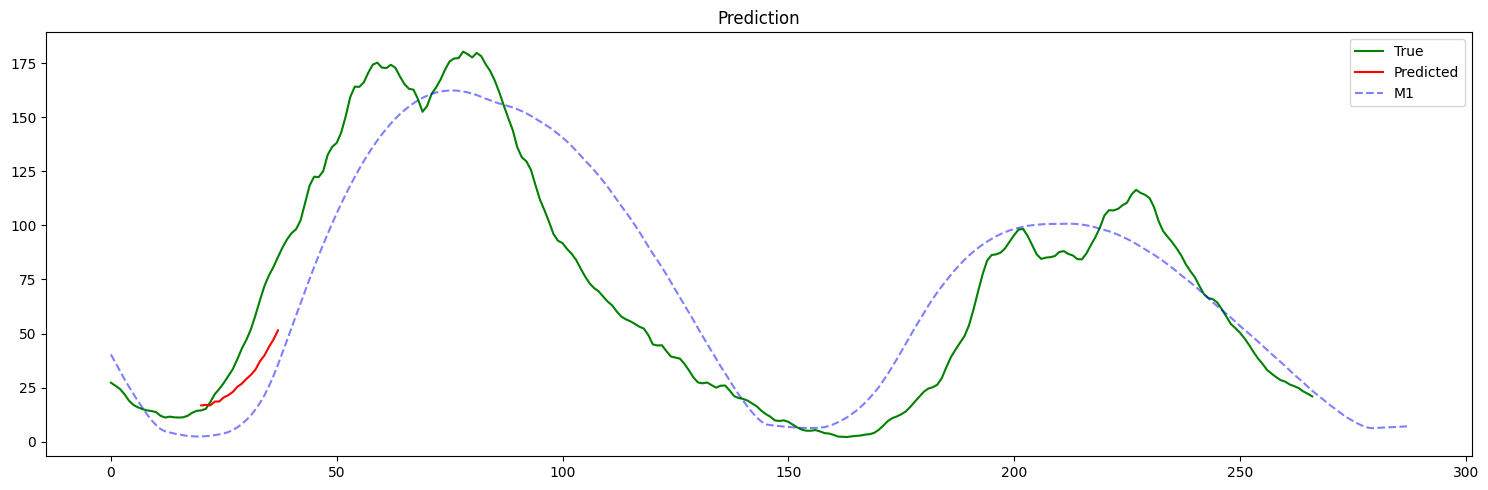

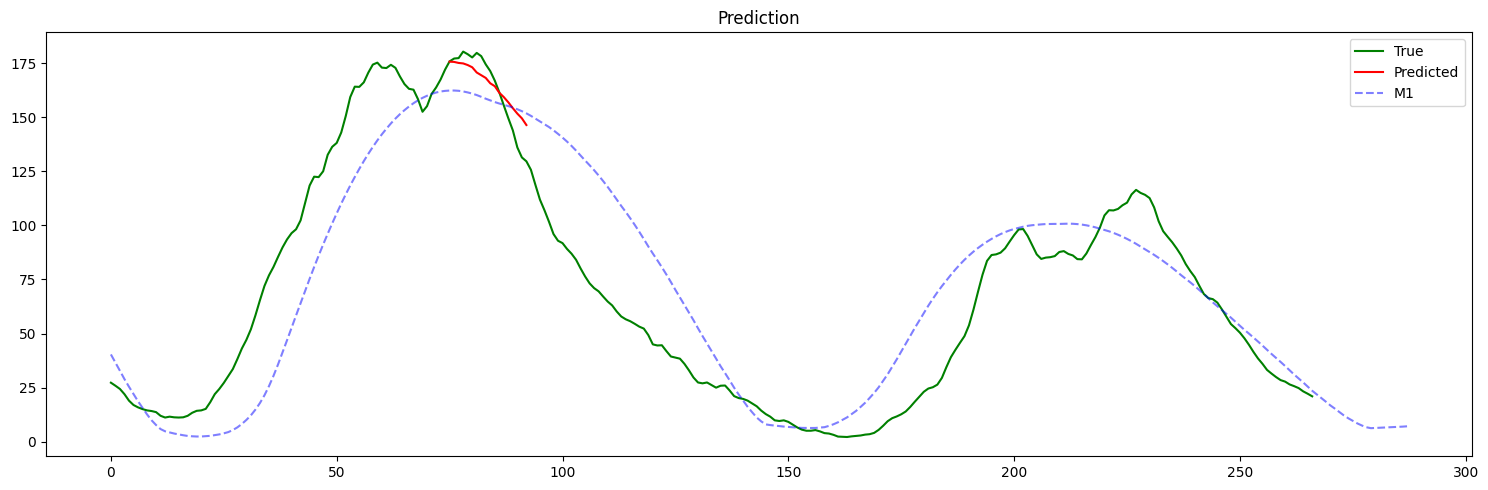

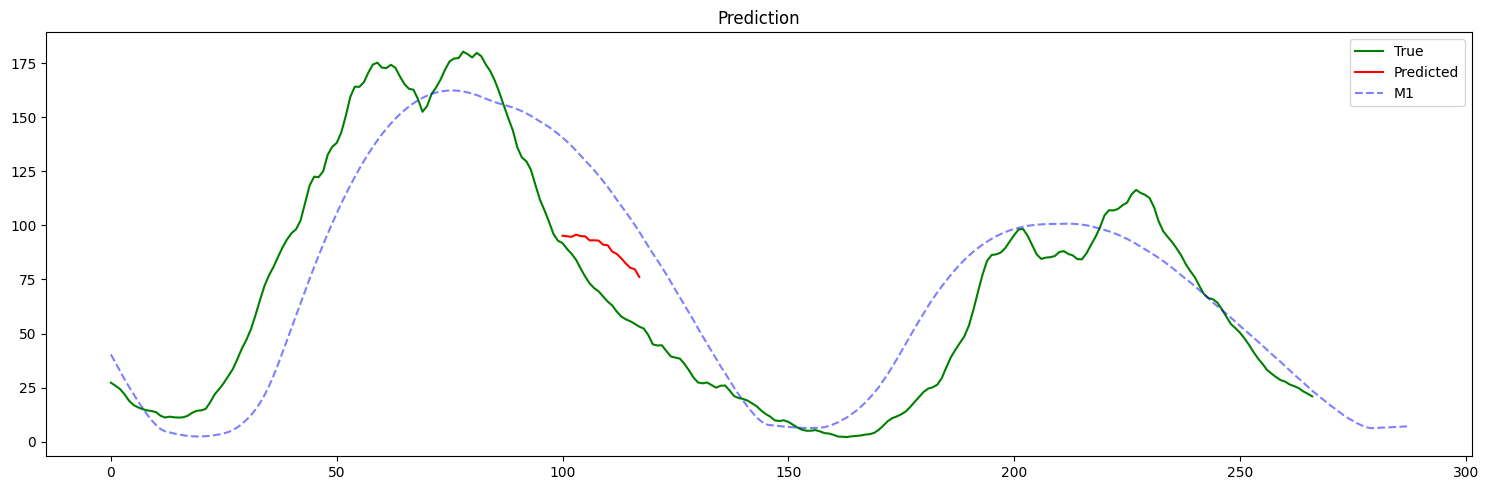

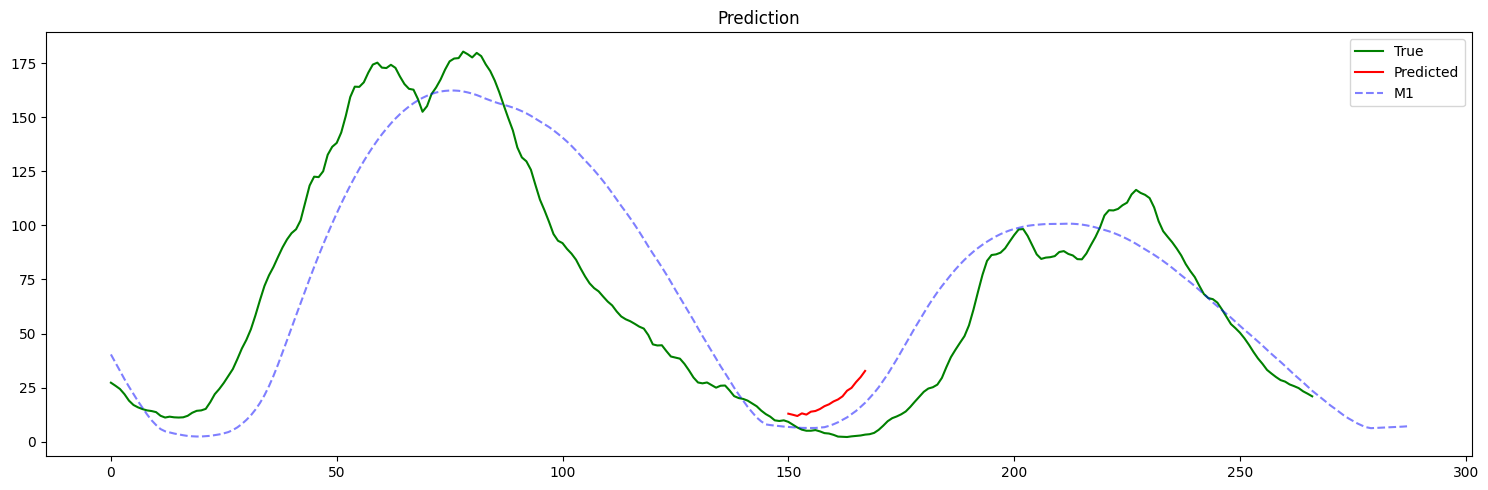

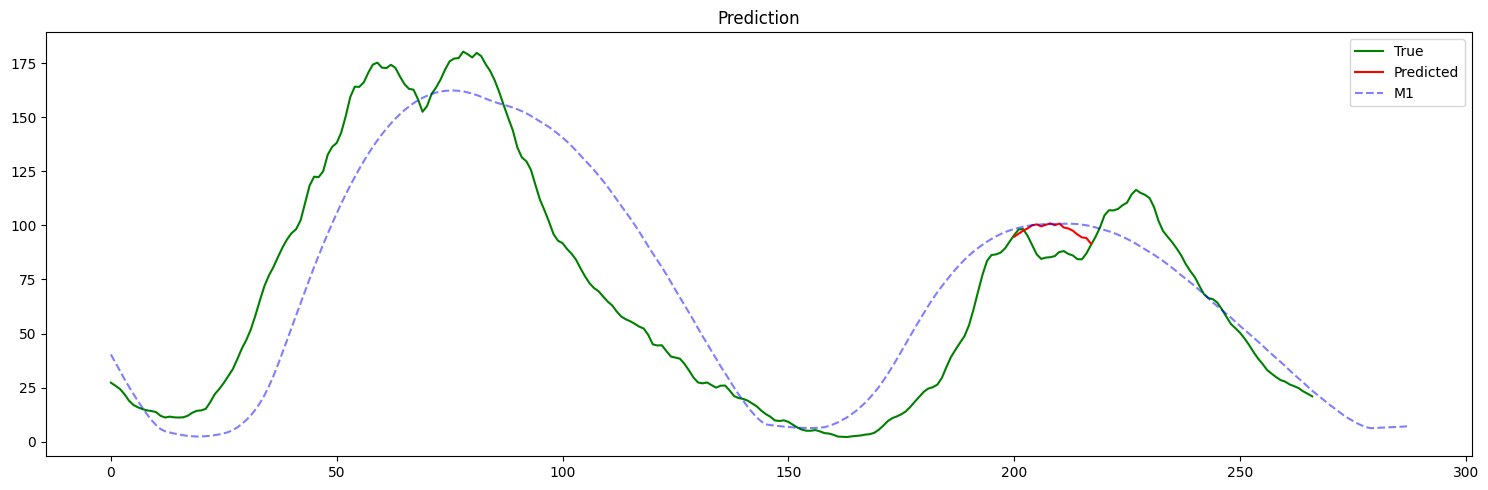

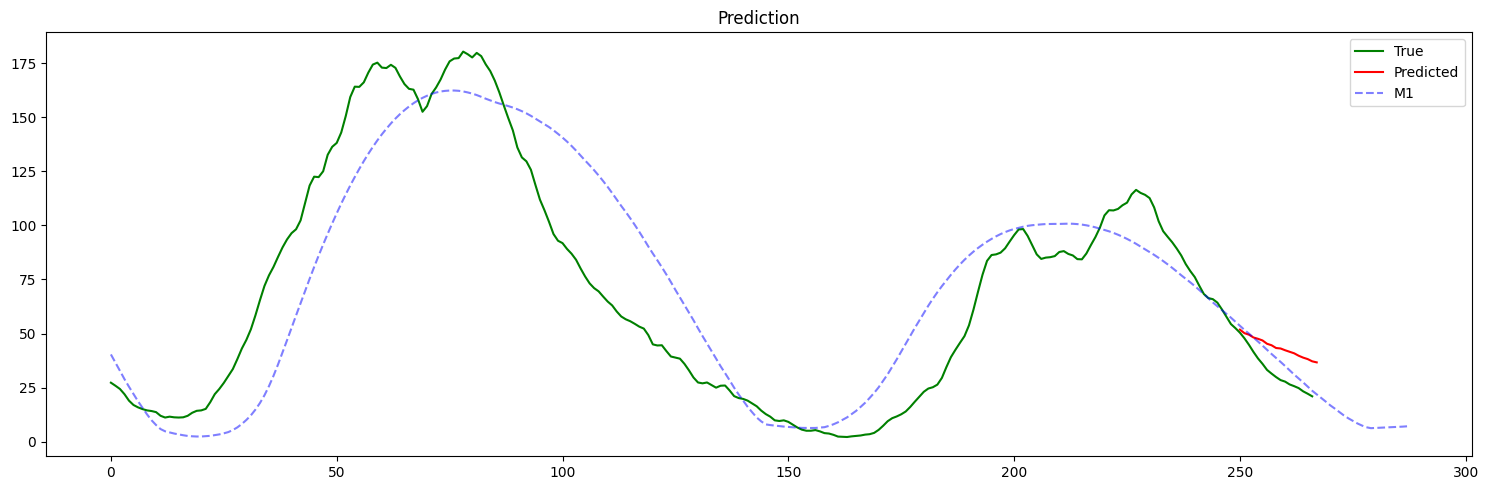

In [128]:
for s in [20, 75, 100, 150, 200, 250]:
    plot_pred(s, '18-forward')